# Test for systematics that become visible by comparison of multiple light curves in a campaign

## Run the LCs through appaloosa

In [148]:
import pandas as pd
import numpy as np
import os
from appaloosa import RunLC
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['font.family'] = 'monospace'
#rcParams['font.sans-serif'] = ['Tahoma']

def RunLC_test(oid):
    loc = 'stars_shortlist/M67'
    tpf_loc = 'stars_shortlist/M67/ktwo{}-c05_lpd-targ.fits.gz'.format(oid)
    lc_loc = 'stars_shortlist/M67/hlsp_everest_k2_llc_{}-c05_kepler_v2.0_lc.fits'.format(oid)
    os.chdir('/home/ekaterina/Documents/appaloosa')
    RunLC(lc_loc, dbmode='everest', display=False, debug=False, dofake=False, writeout=True)
    return

In [147]:
os.chdir('/home/ekaterina/Documents/appaloosa')
oid_list = pd.read_csv('stars_shortlist/M67/M67_short.txt',names=['EPIC'])
oid_list = oid_list.EPIC.tolist()

for oid in listoid_list(oid_list):
    RunLC_test(oid)

## Use the results or jump in here if LCs have been processed earlier

### Import the flare candidates first and reframe as boolean arrays of flare/not flare in time domain

In [150]:
os.chdir('/home/ekaterina/Documents/appaloosa/stars_shortlist/M67/results/test_01')

def edges_to_bool(df):
    rangeflare = []
    for i,row in start_stop.iterrows():
            rangeflare.append(list(range(row.istart,row.istop)))
    isflare = np.zeros(start_stop.istop.iloc[-1]+1)
    rangeflare = [item for sublist in rangeflare for item in sublist]

    np.put(isflare,rangeflare,np.ones_like(rangeflare))
    
    return isflare

all_isflare = {}
for idx, oid in enumerate(oid_list):
    
    start_stop = pd.read_csv(str(oid)+'_flares.csv')
    all_isflare[oid] = edges_to_bool(start_stop)
#print(all_isflare)
maxlen = max([len(val) for key,val in all_isflare.items()])

for key, val in all_isflare.items():
    all_isflare[key] = np.concatenate((val,np.zeros(maxlen-len(val))))
    #print(len(val))
seq = pd.DataFrame(all_isflare)
seq.head()


,211395699,211396422,211403974,211405388,211406540,211407971,211409099,211410963,211411112,211411477,...,211411894,211412571,211413212,211416648,211417817,211418176,211418561,211427268,211427574,228682441
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Remove systematics as time intervals where flares overlap for more than 30% of all LCs

In [151]:
df = seq[5<seq.sum(axis=1)]

systematics = list(df.index)
remove = sorted(list(set([item for sublist in [[i-1,i,i+1] for i in systematics] for item in sublist])))
seq_drop = seq.drop(labels=remove)

overlap_dirty = [seq[seq.sum(axis=1)>=i].shape[0] for i in range(21)]
overlap_clean = [seq_drop[seq_drop.sum(axis=1)>=i].shape[0] for i in range(21)]

#Calculate the binomial probability for cleaned version
p = seq.sum()/maxlen

### Introduce a binomial distribution for comparison, also some where flare time point occur in clusters of 3 or 5 time points

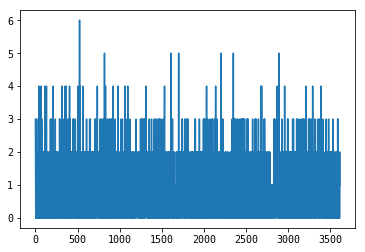

In [152]:
binom = 0
inflated_binoms={}
for i in [1,3,5]:
    for oid in oid_list:
        not_inflated = np.random.binomial(1,p[oid]/i,maxlen//i)
        _ = [[j]*i for j in not_inflated]
        
        inflated = [item for sublist in _ for item in sublist]
        #print(inflated[:5])
        binom = np.add(inflated,binom)
    inflated_binoms[i]=(binom)
plt.plot(inflated_binoms[3])

### Now compare the cleaned version with the uncleaned one and also the (inflated) binomials:

/usr/local/lib/python3.5/dist-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


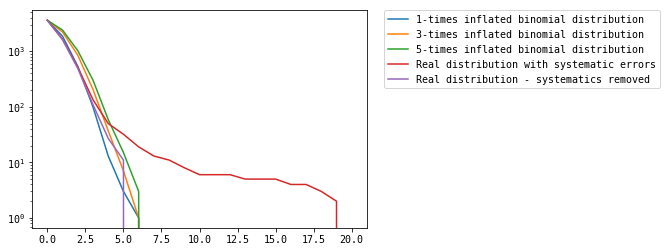

In [153]:

fig = plt.figure()
ax = fig.add_subplot(111)
for i,binom in inflated_binoms.items():
    overlap_binom, edges = np.histogram(binom, bins=21, range=(0,21))
    #print(overlap_binom)
    overlap_binom = np.cumsum(overlap_binom[::-1])[::-1]
    #print(overlap_binom,'\n',overlap)
    ax.plot(overlap_binom,label='{}-times inflated binomial distribution'.format(i))
ax.plot(overlap_dirty,label='Real distribution with systematic errors')
ax.plot(overlap_clean,label='Real distribution - systematics removed')
#ax.plot(np.array(overlap)-overlap_binom,label='real-random')
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax.set_yscale('log')
fig.show()

## Appendix: Example of a systematic in a light curve

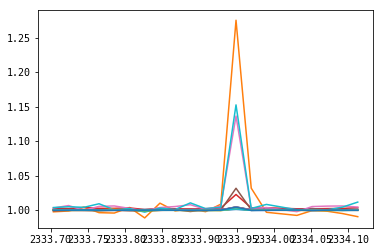

In [155]:
all_flux={}
fig = plt.figure()
ax = fig.add_subplot(111)
for idx, oid in enumerate(oid_list):
    flux = pd.read_csv(str(oid)+'_flux.csv',
                      usecols = ['flux_gap','time'])
    s = 1310
    t = 1330
    mean = flux.flux_gap.median()
    plt.plot(list(flux.time)[s:t],list(flux.flux_gap/mean)[s:t],label='EPIC {}'.format(oid))
plt.show()